In [1]:
import geopandas as gpd
import gerrychain
import maup


## Build the dual graph

In [2]:
data = gpd.read_file('CA_votes_dem_pct.shp')

In [3]:
edges = maup.adjacencies(data)

C:\Users\Mélisande\Anaconda3\envs\VRDI\lib\site-packages\maup\adjacencies.py:52: OverlapWarning: Found overlapping polygons while computing adjacencies.
This could be evidence of topological problems.
Indices of overlaps: {(2264, 2323), (10122, 10129), (22321, 24317), (14634, 24301), (2099, 2243), (3773, 3821), (10635, 10747), (2920, 2993), (7242, 16279), (19976, 20018), (2182, 12079), (2788, 2813), (10040, 10045), (11596, 11597), (14639, 24318), (22366, 22473), (1362, 1371), (11436, 11979), (2893, 2995), (2655, 2836), (13860, 14530), (3330, 3685), (2605, 23445), (11449, 11561), (23715, 24133), (9134, 9150), (2640, 2654), (10757, 10897), (3342, 3343), (9920, 9925), (3709, 3726), (22627, 22631), (10588, 10643), (3693, 3694), (9232, 9276), (3313, 3670), (4090, 9933), (3395, 3396), (11791, 11792), (2890, 2984), (3384, 3463), (14045, 14696), (2373, 2374), (23242, 23249), (10176, 10232), (22429, 22497), (12060, 12116), (22036, 22076), (22869, 22982), (12795, 12799), (11151, 11214), (10309, 

In [4]:
edges.head(2)

0  955    (LINESTRING (-122.2146398167637 37.77720662576...
   273    (LINESTRING (-122.2117859639561 37.77468001344...
dtype: object

In [67]:
 import pickle 

In [68]:
f = open("CA_maup_edges.pkl", "wb") # remember to open the file in binary mode
pickle.dump(edges, f)
f.close()

## Add edges to islands

During the computation of the adjacencies, we are warned about islands at indices 8659, 19380, 3766.
Let's see which precincts these correspond to and we will then look at the map in GIS to determine which precincts are closest and we will add edges to these. 

In [5]:
indices = [8659, 19380, 3766]
for i in indices: 
    print(data.iloc[i]['pct16'])

037-5960001A
075-9900
029-7043101


In QGIS we see that:
- precinct 037-5960001A (San Clemente Island) is closest to precinct 037-6210001A (in Catalina Island)
- precinct 075-9900 is actualy not an island, rather it's an error in the shapefile that created a gap between this precinct and the adjacent precinct (precinct 001-305600). It is located in Alameda, on the part closest to San Francisco.
- precinct 029-7043101 doesn't seem to be an island... but since we got a warning, we'll add edges to adjacent precincts : 029-7041242, 029-7041528,029-7041933. 

Moreover precincts 037-6210001A, 037-6210002A, 037-0500001A, 037-0500003A form the Catalina Island (fish conservation habitat), but we are not warned about them not being linked to mainland California, as they are not 0 degree nodes. But we still need to link them to the rest of California to have one single connected component for the state. 
Actually one could argue that it would first be more relevant to check if there is any population in these islands. Indeed if population is 0, we don't even need to add all edges to close coastines precincts. Let's do this check.

In [25]:
for elem in ["037-5960001A", "075-9900", "029-7043101", "037-6210001A", "037-6210002A", "037-0500001A", "037-0500003A" ]:
    print(data[data.pct16 == elem]["TOTPOP"])

8659    6.0
Name: TOTPOP, dtype: float64
19380    0.0
Name: TOTPOP, dtype: float64
3766    0.0
Name: TOTPOP, dtype: float64
4795    302.0
Name: TOTPOP, dtype: float64
4197    60.0
Name: TOTPOP, dtype: float64
6710    1145.0
Name: TOTPOP, dtype: float64
6645    2583.0
Name: TOTPOP, dtype: float64


The population is not 0. So we need to link the Catalina island to mainland California.
In QGIS we can select the coastline precincts that will have to be linked to Catalina precincts. 


In [26]:
coastline_pct = ['037-3850184A', '037-3850198A', '037-3850213A', '037-3850264A', '037-3850285A', '037-3850545A', '037-5050001A', '037-5530027A','037-5530033A', '037-5530040A', '037-5530053A', '037-9000420A', '037-9001006A','037-9001483A','037-9001827A','037-9002688A','037-9002689A','037-9002698A','037-9007628A']

Now we need to find the indices corresponding to the precincts in order to add the edges to the graph/

In [36]:
coastline_indices = []
for elem in coastline_pct:
    coastline_indices.append(data.index[data['pct16']== elem].to_list()[0])

In [49]:
catalina_indices = []
for elem in catalina:
    catalina_indices.append(data.index[data['pct16']== elem].to_list()[0])
catalina_indices

[4795, 4197, 6710, 6645]

We want to keep Catalina island together, so let's just add edges from one of the precincts constituting Catalina. 

In [50]:
catalina_index = 4795

In [52]:
coastline_edge_pairs = []
for island_pct in [catalina_index]:
    for mainland_pct in coastline_indices:
        coastline_edge_pairs.append((island_pct, mainland_pct))

In [53]:
 coastline_edge_pairs

[(4795, 7703),
 (4795, 7884),
 (4795, 8351),
 (4795, 7880),
 (4795, 8453),
 (4795, 7567),
 (4795, 4653),
 (4795, 8721),
 (4795, 8782),
 (4795, 8867),
 (4795, 4688),
 (4795, 5810),
 (4795, 6085),
 (4795, 5107),
 (4795, 5393),
 (4795, 5414),
 (4795, 5082),
 (4795, 5106),
 (4795, 6211)]

In [58]:
# for the precinct that did not seem to be an island but was flagged as island
flagged_pct = '029-7043101' 
adjacent_pct = ['029-7041242', '029-7041528','029-7041933']

In [59]:
adjacent_pct_idx = []
for elem in adjacent_pct:
    adjacent_pct_idx.append(data.index[data['pct16']== elem].to_list()[0])
flagged_idx = data.index[data['pct16']== flagged_pct].to_list()[0]

In [60]:
flagged_pct_edges = []
for adj in adjacent_pct_idx:
    flagged_pct_edges.append((flagged_idx, adj))

In [61]:
flagged_pct_edges

[(3766, 3732), (3766, 3743), (3766, 3750)]

#### Let's add the edges

In [48]:
graph = gerrychain.Graph(list(edges.index))

In [55]:
#Catalina linked to mainland
graph.add_edges_from(coastline_edge_pairs)

In [57]:
#link San Clemente to Catalina
graph.add_edges_from([(data.index[data['pct16']== "037-5960001A"].to_list()[0] , catalina_index)])

In [62]:
#link flagged precinct
graph.add_edges_from(flagged_pct_edges)

In [64]:
#link Alameda
graph.add_edges_from([(data.index[data['pct16']== "075-9900"].to_list()[0] , (data.index[data['pct16']== "001-305600"].to_list()[0]))])


Precincts "075-7647" and "075-7648" (index 19076) also form a connected component disconnected from the rest of CA so we will add edges from "075-7648" to precincts "001-335000" and "075-7638" as there are bridges.

In [109]:
graph.add_edges_from([(data.index[data['pct16']==  "075-7648" ].to_list()[0] , (data.index[data['pct16']== "001-335000"].to_list()[0]))])
graph.add_edges_from([(data.index[data['pct16']==  "075-7648" ].to_list()[0] , (data.index[data['pct16']== "075-7638"].to_list()[0]))])


In [84]:
data.columns

Index(['pct16', 'area', 'pres_clint', 'pres_trump', 'pres_johns', 'pres_stein',
       'pres_lariv', 'pres_other', 'ussenate_h', 'ussenate_s',
       ...
       'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'geometry'],
      dtype='object', length=103)

In [88]:
data.fillna(0, inplace=True)

In [89]:
graph.add_data(data)

In [110]:
graph.to_json('CA_graph.json')

### Run a chain for Congressional district plans

In [70]:
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges, county_splits,compactness
from gerrychain.tree import recursive_tree_part

In [71]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = 5*np.arange(data.shape[1])+1+offset
    #bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    bp = ax.boxplot(data, positions= pos,widths=.5, whis=[1,99],showfliers=False, patch_artist=True, manage_xticks=False,zorder=4)
    for element in ['boxes', 'whiskers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color,zorder=4)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,zorder=0)


In [72]:
num_districts = 53
unique_label = "pct16"
pop_col = "TOTPOP"

In [126]:
totpop = 0

In [128]:

for n in graph.nodes():
    #graph.node[n]["pres_clint"] = int(graph.node[n]["pres_clint"])
    #graph.node[n]["pres_trump"] = int(graph.node[n]["pres_trump"])
    graph.node[n]["TOTPOP"] = int(graph.node[n]["TOTPOP"])
    graph.node[n]["TOTVOTES"] = int(graph.node[n]["pres_trump"]) + int(graph.node[n]["pres_clint"])+ \
    int(graph.node[n]["pres_johns"]) + int(graph.node[n]["pres_stein"])+ int(graph.node[n]["pres_lariv"])\
    + int(graph.node[n]["pres_other"])
    graph.node[n]["VAP"] = int(graph.node[n]["VAP"])
    graph.node[n]["BVAP"] = int(graph.node[n]["BVAP"])
    graph.node[n]["HVAP"] = int(graph.node[n]["HVAP"])
    graph.node[n]["WVAP"] = int(graph.node[n]["WVAP"])
    graph.node[n]["ASIANVAP"] = int(graph.node[n]["ASIANVAP"])
    graph.node[n]["WVAP"] = int(graph.node[n]["WVAP"])
    graph.node[n]["nASIANVAP"] =  graph.node[n]["VAP"] - graph.node[n]["ASIANVAP"]
    graph.node[n]["nBVAP"] =  graph.node[n]["VAP"] - graph.node[n]["BVAP"]
    graph.node[n]["nHVAP"] =  graph.node[n]["VAP"] - graph.node[n]["HVAP"]
    graph.node[n]["nWVAP"] =  graph.node[n]["VAP"] - graph.node[n]["WVAP"]
    if graph.node[n]["VAP"]!= 0:
        graph.node[n]["TURNOUT"] =  graph.node[n]["TOTVOTES"]/graph.node[n]["VAP"]
    else: 
        graph.node[n]["TURNOUT"] = -1
    totpop +=graph.node[n]["TOTPOP"]
    

In [212]:
updater = {
        "population": updaters.Tally("TOTPOP", alias="population"),
    "TOTVOTES": updaters.Tally("TOTVOTES", alias="TOTVOTES"),
    "VAP": updaters.Tally("VAP", alias="VAP"),
    "cut_edges": cut_edges,
    "BVAP":Election("BVAP",{"BVAP":"BVAP","nBVAP":"nBVAP"}),
    "HVAP":Election("HVAP",{"HVAP":"HVAP","nHVAP":"nHVAP"}),
    "WVAP":Election("WVAP",{"WVAP":"WVAP","nWVAP":"nWVAP"}),
    "ASIANVAP":Election("ASIANVAP",{"ASIANVAP":"ASIANVAP","nASIANVAP":"nASIANVAP"}),
    "2016_pres": Election("2016_pres", {"pres_trump": "pres_trump","pres_clint": "pres_clint"})
}



Let's just check that total population seems consistent with Census Bureau data of 39,21 million Californians in 2016.

In [198]:
totpop

37242932

##  Let's chain

In [199]:
from gerrychain.tree import bipartition_tree

def recursive_tree_part(
    graph, parts, pop_target, pop_col, epsilon, node_repeats=1, method=bipartition_tree
):
    """Uses :func:`~gerrychain.tree_methods.bipartition_tree` recursively to partition a tree into
    ``len(parts)`` parts of population ``pop_target`` (within ``epsilon``). Can be used to
    generate initial seed plans or to implement ReCom-like "merge walk" proposals.

    :param graph: The graph
    :param parts: Iterable of part labels (like ``[0,1,2]`` or ``range(4)``
    :param pop_target: Target population for each part of the partition
    :param pop_col: Node attribute key holding population data
    :param epsilon: How far (as a percentage of ``pop_target``) from ``pop_target`` the parts
        of the partition can be
    :param node_repeats: Parameter for :func:`~gerrychain.tree_methods.bipartition_tree` to use.
    :return: New assignments for the nodes of ``graph``.
    :rtype: dict
    """
    flips = {}
    remaining_nodes = set(graph.nodes)
    # We keep a running tally of deviation from ``epsilon`` at each partition
    # and use it to tighten the population constraints on a per-partition
    # basis such that every partition, including the last partition, has a
    # population within +/-``epsilon`` of the target population.
    # For instance, if district n's population exceeds the target by 2%
    # with a +/-2% epsilon, then district n+1's population should be between
    # 98% of the target population and the target population.
    debt = 0

    for part in parts[:-1]:
        min_pop = max(pop_target * (1 - epsilon), pop_target * (1 - epsilon) - debt)
        max_pop = min(pop_target * (1 + epsilon), pop_target * (1 + epsilon) - debt)
        nodes = method(
            graph.subgraph(remaining_nodes),
            pop_col=pop_col,
            pop_target=(min_pop + max_pop) / 2,
            epsilon=(max_pop - min_pop) / (2 * pop_target),
            node_repeats=node_repeats,
        )

        part_pop = 0
        for node in nodes:
            flips[node] = part
            part_pop += graph.nodes[node][pop_col]
        debt += part_pop - pop_target
        remaining_nodes -= nodes

    # All of the remaining nodes go in the last part
    for node in remaining_nodes:
        flips[node] = parts[-1]

    return flips


In [200]:
start = recursive_tree_part(graph,range(num_districts),round(totpop/num_districts),"TOTPOP", .02,1)

In [213]:
initial_partition =Partition(graph,start, updater)

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

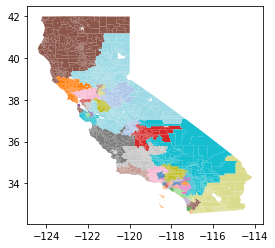

In [214]:
initial_partition.plot(data, cmap = 'tab20')

In [165]:
from functools import partial

In [224]:
proposal = partial(
        recom, pop_col="TOTPOP", pop_target=totpop/num_districts, epsilon=0.05, node_repeats=1)
compactness_bound =constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2* len(initial_partition["cut_edges"] ))
    
MC = MarkovChain(
    proposal=proposal,
    constraints=[
    constraints.within_percent_of_ideal_population(initial_partition, 0.05),compactness_bound
     # constraints.single_flip_contiguous#no_more_discontiguous
    ],
    accept = accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)


chain 3766 step 100
chain 3766 step 200
chain 3766 step 300
chain 3766 step 400
chain 3766 step 500
chain 3766 step 600
chain 3766 step 700
chain 3766 step 800
chain 3766 step 900
chain 3766 step 1000
finished chain 3766


<Figure size 432x288 with 0 Axes>

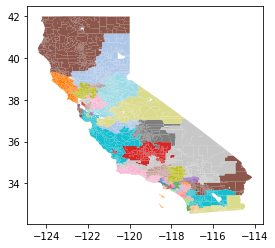

<Figure size 432x288 with 0 Axes>

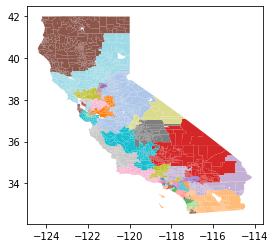

<Figure size 432x288 with 0 Axes>

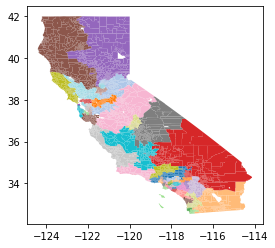

<Figure size 432x288 with 0 Axes>

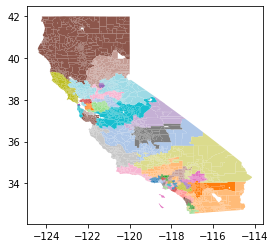

<Figure size 432x288 with 0 Axes>

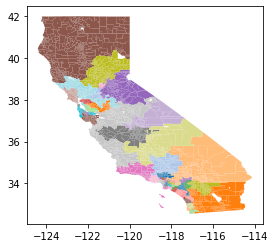

<Figure size 432x288 with 0 Axes>

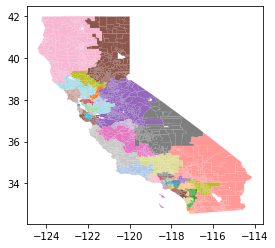

<Figure size 432x288 with 0 Axes>

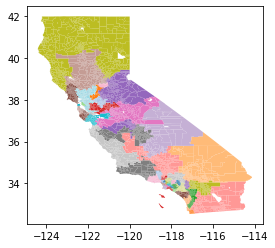

<Figure size 432x288 with 0 Axes>

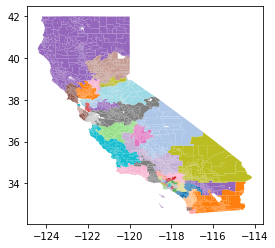

<Figure size 432x288 with 0 Axes>

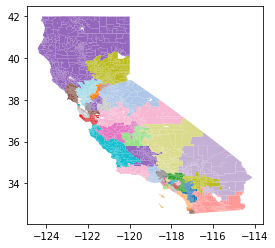

<Figure size 432x288 with 0 Axes>

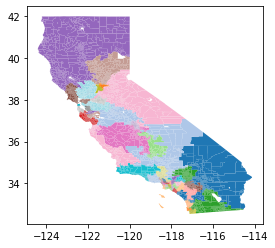

In [227]:
cuts = []

BVAPs = []
ASIANVAPs = []
HVAPs = []
WVAPs = []
VAP_ = []
population = []
clint2016 = []
trump2016 = []
totvotes = []
paths = []

t = 0

for part in MC:

    population.append(part["population"])
    totvotes.append(part["TOTVOTES"])
    cuts.append(len(part["cut_edges"]))
    BVAPs.append(sorted(part["BVAP"].percents("BVAP")))
    ASIANVAPs.append(sorted(part["ASIANVAP"].percents("ASIANVAP")))
    HVAPs.append(sorted(part["HVAP"].percents("HVAP")))
    VAP_.append(part["VAP"])
    WVAPs.append(sorted(part["WVAP"].percents("WVAP")))
    clint2016.append(sorted(part["2016_pres"].percents("pres_clint")))
    trump2016.append(sorted(part["2016_pres"].percents("pres_trump")))

    t+=1

    if t%100 ==0:
        print("chain",i,"step",t)
        part.to_json('part_CA'+str(t)+'.json', save_assignment_as = 'assign')
        plt.figure()
        part.plot(data,  cmap = 'tab20')
        plt.plot()
        plt.savefig('./test2_'+str(t)+'.png')
        path = './test2_'+str(t)+'.png'
        paths += path
print(f"finished chain {i}")


In [229]:
VAP_

[defaultdict(int,
             {0: 518068,
              1: 524662,
              2: 528149,
              3: 538496,
              4: 511488,
              5: 499142,
              6: 500009,
              7: 544841,
              8: 506984,
              9: 543190,
              10: 514726,
              11: 538523,
              12: 584006,
              13: 552787,
              14: 516137,
              15: 539853,
              16: 483426,
              17: 474590,
              18: 553208,
              19: 498892,
              20: 528792,
              21: 607673,
              22: 522140,
              23: 494761,
              24: 523937,
              25: 517654,
              26: 556108,
              27: 525072,
              28: 557271,
              29: 530374,
              30: 530205,
              31: 551988,
              32: 537161,
              33: 495806,
              34: 538823,
              35: 577312,
              36: 551601,
              37: 505913,
    